In [53]:
import numpy as np
import zarr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

RUNTIME = 300 #seconds
# root = zarr.open("/mnt/c/Users/Anthony/Desktop/test.zarr", mode="r")
# test = zarr.open("../../results_GOOD.zarr", mode="r")
# test = zarr.open("/home/anthony/idev/patrolling_sim/results.zarr", mode="r")
# test.tree()
# print([i/1.0e9 for i in test["cumberland_6"]["AHPA"]["run_1"]["attrition_times"]])

In [54]:
def analyzeRun(run: zarr.hierarchy):
    # print(f"Analyze {run.name}")

    numNodes = run["graph"].shape[0]
    numAgents = run["origins"].shape[0]

    times = np.array(run["visits"]["time_ns"]) / 1.0e9 #seconds to ns
    data = np.transpose(np.vstack([times, run["visits"]["agent"], run["visits"]["node"]]))
    # print(data.shape)
    # print(data[np.where(data[:,2] == 5)])

    # print(f"Attrition times: {[(i/1.0e9, j) for i,j in run['attrition_times']]}")

    idleness = np.ndarray((RUNTIME + 1, numNodes + 1))
    idleness[:,0] = range(RUNTIME + 1)
    for i in range(numNodes):
        nodeVisits = data[np.where(data[:,2] == i)]

        # Add beginning and end.
        nodeVisits = np.append([[0, 0, i]], nodeVisits, axis=0)
        nodeVisits = np.append(nodeVisits, [[RUNTIME, 0, i]], axis=0)

        # nodeIdleness = []
        idl = 0.0
        visitIdx = 0

        for t in range(RUNTIME + 1):
            if visitIdx + 1 < nodeVisits.shape[0] and t > nodeVisits[visitIdx + 1][0]:
                visitIdx += 1
            idl = t - nodeVisits[visitIdx][0] 
            idleness[t][i + 1] = idl
    
    messages = np.ndarray((RUNTIME + 1, 1))
    commTimes = np.array(run["comm_times"]) / 1.0e9
    for i in range(RUNTIME + 1):
        messages[i] = np.count_nonzero(commTimes < i)

    return idleness, messages

def analyzeAlg(alg):
    idleness = np.ndarray((RUNTIME + 1, 1))
    idleness[:,0] = range(RUNTIME + 1)
    messages = np.ndarray((RUNTIME + 1, 1))
    messages[:,0] = range(RUNTIME + 1)
    for run in alg:
        try:
            idl, msgs = analyzeRun(alg[run])
        except KeyError as e:
            print(f"A run for algorithm {alg} has invalid data!")
            continue

        # displayAverageIdleness([idl], ["idleness"], title=f"{alg.name}/{run}", attrition=bool(alg[run]["attrition_times"].size > 0))
        idleness = np.concatenate([idleness, idl[:,1:]], axis=1)
        messages = np.concatenate([messages, msgs], axis=1)
    return idleness, messages

def analyzeFile(filePath, mapName="L440_6", simulation=True, attritionTimes=[], excludeDta=False):
    root = zarr.open(filePath, mode="r")
    labels = []
    results = []
    mapDisplayName = mapName.split("_")[0].capitalize()
    msgResults = []
    for algName in root[mapName]:
        if excludeDta and "DTA" in algName:
            continue
        print(f"Algorithm {algName} has {len(root[mapName][algName])} runs.")
        idleness, messages = analyzeAlg(root[mapName][algName])
        print(f"  Max average idleness: {np.max(np.mean(idleness[:,1:], axis=1))}")
        results.append(idleness)
        msgResults.append(messages)
        algDisplayName = algName
        if algDisplayName == "DTAGreedy":
            algDisplayName = "DTAG"
        elif algDisplayName == "DTASSIPart":
            algDisplayName = "DTAP"
        labels.append(algDisplayName)
    
    # Set font sizes.
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('figure', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

    # Set up the plot.
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(PLOT_X, PLOT_Y))
    (axAvgIdleness, axStdIdleness, axMsgs) = axes
    fig.supxlabel("Time Elapsed (s)")
    attritionDisplayStr = "No Attrition" if attritionTimes == [] else "Attrition"
    simulationDisplayStr = "Sim." if simulation else "Real-World"
    title = f"{mapDisplayName} {simulationDisplayStr} ({attritionDisplayStr})"
    fig.suptitle(title)
    axes[0].set_title("(a)", loc="left")
    axes[1].set_title("(b)", loc="left")
    axes[2].set_title("(c)", loc="left")

    # Build the legend.
    # cmap = plt.get_cmap("tab10")
    # handles = []
    # for i in range(len(labels)):
    #     handles.append(mpatches.Patch(color=cmap(i), label=labels[i]))
    # axLegend.clear()
    # axLegend.set_axis_off()
    # axLegend.legend(handles=handles, loc="center")

    
    displayAverageIdleness(axAvgIdleness, results, labels, attritionTimes=attritionTimes)
    displayStdIdleness(axStdIdleness, results, labels, attritionTimes=attritionTimes)
    displayMessages(axMsgs, msgResults, labels, attritionTimes=attritionTimes)

    axAvgIdleness.legend()
    fig.tight_layout()


    # Save the figure.
    fig.savefig(title.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").lower() + ".png")


def analyzeFiles(filePaths, mapName="cumberland_6", simulation=True, attritionTimes=[], excludeDta=[]):

    labels = []
    results = []
    msgResults = []
    for i, filePath in enumerate(filePaths):
        fLabels = []
        fResults = []
        fMsgResults = []
        root = zarr.open(filePath, mode="r")
        mapDisplayName = mapName.split("_")[0].capitalize()
        for algName in root[mapName]:
            if excludeDta[i] and "DTA" in algName:
                idleness = None
                messages = None
            else:
                idleness, messages = analyzeAlg(root[mapName][algName])
            fResults.append(idleness)
            fMsgResults.append(messages)
            algDisplayName = algName
            if algDisplayName == "DTAGreedy":
                algDisplayName = "DTAG"
            elif algDisplayName == "DTASSIPart":
                algDisplayName = "DTAP"
            if excludeDta[i] and "DTA" in algName:
                algDisplayName = "_" + algDisplayName
            fLabels.append(algDisplayName)
        labels.append(fLabels)
        results.append(fResults)
        msgResults.append(fMsgResults)
    
    # Set font sizes.
    SMALL_SIZE = 16
    MEDIUM_SIZE = 20
    BIGGER_SIZE = 24
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    plt.rc('figure', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels

    # Set up the plot.
    fig, axes = plt.subplots(3, len(filePaths), sharex=True, figsize=(PLOT_X, PLOT_Y))
    fig.supxlabel("Time Elapsed (s)")
    simulationDisplayStr = "Simulation" if simulation else "Real-World"
    title = f"{mapDisplayName} - {simulationDisplayStr}"
    fig.suptitle(title, x=0.575)

    # alphabet = "abcdefghijklmnopqrstuvwxyz"
    for i in range(3):
        for j in range(len(filePaths)):
            if len(filePaths) == 1:
                ax = axes[i]
            else:
                ax = axes[i][j]

            # ax.set_title(f"({alphabet[i * 3 + j]})", loc="left")
            if i == 0:
                allAlgsDisplayStr = "DTA* Excluded" if excludeDta[j] else "All Algorithms"
                attritionDisplayStr = "No Attrition" if attritionTimes[j] == [] else "Attrition"
                ax.set_title(f"{allAlgsDisplayStr}, {attritionDisplayStr}")
                # ax.set_title(f"{attritionDisplayStr}")

            if i == 0:
                displayAverageIdleness(ax, results[j], labels[j], attritionTimes=attritionTimes[j], addYLabel=(j == 0))
            elif i == 1:
                displayStdIdleness(ax, results[j], labels[j], attritionTimes=attritionTimes[j], addYLabel=(j == 0))
            elif i == 2:
                displayMessages(ax, msgResults[j], labels[j], attritionTimes=attritionTimes[j], addYLabel=(j == 0))

    if len(filePaths) == 1:
        axes[0].legend()
    else:
        axes[0][0].legend()
    fig.tight_layout()

    # Save the figure.
    fig.savefig(title.replace(" ", "_").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").lower() + ".png")

def displayAverageIdleness(axis, inputs, labels, attritionTimes=[],
        title="Average Node Idleness vs. Time",
        addYLabel=True
    ):
    for arr, name in zip(inputs, labels):
        if arr is None:
            axis.plot([], label=name)
        else:
            axis.plot(np.mean(arr[:,1:], axis=1), label=name)
    # axis.legend()
    # axis.xlabel("Time (s)")
    if addYLabel:
        axis.set(ylabel="Avg. Node Idlnss (s)")
    if len(attritionTimes) > 0:
        # axis.set_title(f"{title} (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title(f"{title} (No Attrition)")
        pass

def displayStdIdleness(axis, inputs, labels, attritionTimes=[], addYLabel=True):
    for arr, name in zip(inputs, labels):
        if arr is None:
            axis.plot([], label=name)
        else:
            axis.plot(np.std(arr[:,1:], axis=1), label=name)
    # plt.xlabel("Time (s)")
    if addYLabel:
        axis.set(ylabel="Std. Node Idlnss (s)")
    if len(attritionTimes) > 0:
        # axis.set_title("Std. Dev. of Node Idleness vs. Time (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title("Std. Dev. of Node Idleness vs. Time (No Attrition)")
        pass

def displayMessages(axis, inputs, labels, attritionTimes=[],
        title="Messages Broadcast vs. Time",
        addYLabel=True
    ):
    for arr, name in zip(inputs, labels):
        if arr is None:
            axis.plot([], label=name)
        else:
            axis.plot(np.mean(arr[:,1:], axis=1), label=name)
    # plt.xlabel("Time (s)")
    if addYLabel:
        axis.set(ylabel="Cum. Messages")
    if len(attritionTimes) > 0:
        # axis.set_title(f"{title} (With Attrition)")
        for t in attritionTimes:
            axis.axvline(t, color="black", ls="--", lw=1.0)
            axis.text(t + 0.1,0,'attrition',rotation=90)
    else:
        # axis.set_title(f"{title} (No Attrition)")
        pass

# analyzeRun(zarr.open("/mnt/c/Users/Anthony/Desktop/results_noattrit3.zarr", "r")["cumberland_6"]["DTAGreedy"]["run_1"])

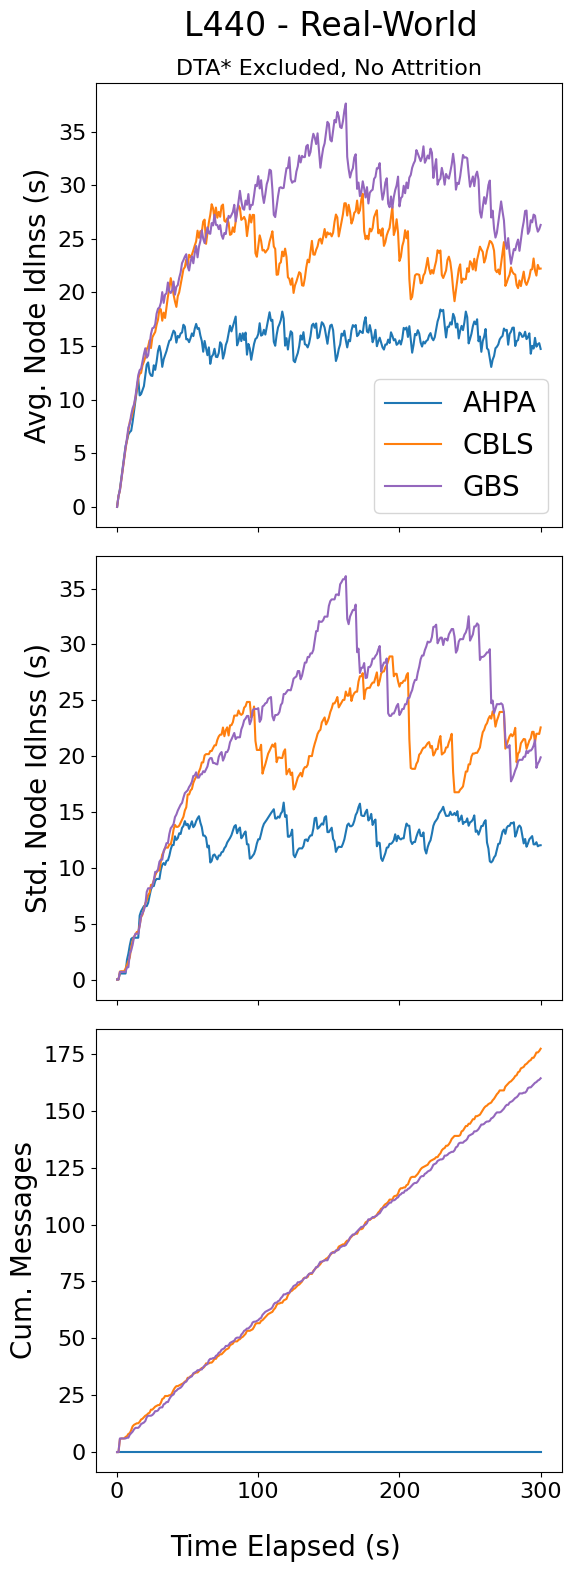

In [55]:
PLOT_X = 6
PLOT_Y = 16

# analyzeFile("/mnt/c/Users/Anthony/Desktop/test_L440.zarr")
# analyzeFile("/home/anthony/idev/project_ahpa/results_clean.zarr", simulation=False)
# analyzeFile("/mnt/c/Users/Anthony/Desktop/results_attrition1.zarr", attritionTimes=[300, 1300]) # USE IN PAPER

analyzeFiles([
        # "/home/anthony/idev/project_ahpa/results_clean.zarr",
        "/home/anthony/idev/project_ahpa/results_clean.zarr"
    ],
    mapName="L440_6",
    simulation=False,
    attritionTimes=[
        # [],
        []
    ],
    excludeDta=[
        # False,
        True
    ])